In [6]:
import sys
import os
sys.path.append("../../marineHeatWaves/")
sys.path.append("../analysis/physiology/")

import marineHeatWaves as mh

from tpc import tpc

import xarray as xr
import numpy as np
import zarr

from shapely import geometry, wkt

import sentinelsat
import satpy
from requests import auth, get

coda_auth = auth.HTTPBasicAuth('tonycan', os.environ['ss_pass'])

api_url='https://coda.eumetsat.int/'

import pandas as pd

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

from dask.distributed import Client

import cloudpickle

import gcsfs
import s3fs 
import boto3

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

# Phytoplankton Isolate Candidates for S3 Validation

Trying to determine here which are the *ideal* isolates to attempt to identify in Sentnel 3 OLCI imagery a signal of MHW impacts esimated via TPCs. 

Possible criteria:

* During a MHW event
* Significant measureable impact in performance due to MHW
* Not close to coast? 

## Load SST + Plankton

In [7]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

plankton = plankton[
    (plankton.habitat == 'marine') & 
    (plankton.curvequal == 'good')
]


plankton.head()

In [8]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [9]:
isolate_performance_perf = xr.open_zarr("../data/isolate_mhw_performance.zarr/isolate_mhw_performance.zarr/")

## Identify MHW statistics for these Isolates. 

In [10]:
def compute_mhw_performance(df):
    isolate_optimal_performance = plankton[plankton['isolate.code'] == df.isolate.min()]['mu.g.opt.val.list'].values[0]
    performance_detriment_mhw = isolate_optimal_performance - df.performance
    performance_detriment_clim = isolate_optimal_performance - df.performance_clim
    return pd.Series({
        'isolate' : df.isolate.min(),
        'detriment_sum' : performance_detriment_mhw.sum(),
        'relative_detriment_mean' : (performance_detriment_mhw / isolate_optimal_performance).mean(),
        'detriment_mean' : performance_detriment_mhw.mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'intensity_mean': df.intensity_mean.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'peak_doy' : oisst.time[int(df.index_peak.min())].dt.dayofyear.item(),
        'perf_det_ratio' : (performance_detriment_mhw / performance_detriment_clim).mean()
    })


In [85]:
mhws = isolate_performance_perf.where((isolate_performance_perf.mhw != 0)).unify_chunks()

In [86]:
### LIMIT TO AFTER 2016?? 2018??

In [87]:
mhws = mhws.where(mhws.time >= np.datetime64('2016-01-01'), drop=True)

In [88]:
mhws_ddf = mhws.to_dask_dataframe().dropna().repartition(npartitions=20)

In [89]:
mhws_ddf.performance = mhws_ddf.performance.mask(mhws_ddf.performance < 0, 0)
mhws_ddf.performance_clim = mhws_ddf.performance_clim.mask(mhws_ddf.performance_clim < 0, 0)

In [90]:
mhws_ddf

,isolate,time,lat,lon,clim_seas,clim_thresh,duration,index_end,index_peak,index_start,intensity_cumulative,intensity_max,intensity_mean,intensity_var,mhw,performance,performance_clim,rate_decline,rate_onset,tmax,tmin,topt
npartitions=20,,,,,,,,,,,,,,,,,,,,,,
0,int64,datetime64[ns],float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5041,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93159,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97543,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [91]:
%%time
a = mhws_ddf.groupby(['lat', 'lon', 'isolate', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 6.37 s, sys: 904 ms, total: 7.27 s
Wall time: 6.5 s


In [92]:
a = a.replace([-np.inf, np.inf], np.nan)

In [93]:
a = a.drop('isolate', axis=1).reset_index()


In [94]:
a['latbin'] = pd.cut(a['lat'], bins=10, )
a['doy_bins'] = pd.cut(a['start_doy'], bins=4)

In [95]:
a.head()

,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,intensity_cumulative,intensity_mean,duration,start_doy,peak_doy,perf_det_ratio,latbin,doy_bins
0,-57.875,139.875,558,67.0,4.836084,0.161783,0.053144,-4.652639,0.843029,130.487813,1.418346,92.0,9.0,50.0,10443.619820,"(-59.75, -44.625]","(0.641, 90.75]"
1,-46.875,168.125,14,64.0,1.832316,0.435134,0.458079,0.473795,1.248740,5.655657,1.131131,5.0,44.0,45.0,0.794550,"(-59.75, -44.625]","(0.641, 90.75]"
2,-46.875,168.125,14,72.0,17.767631,0.843883,0.888382,2.508984,4.243312,23.680309,1.127634,21.0,219.0,227.0,0.876260,"(-59.75, -44.625]","(180.5, 270.25]"
3,-36.125,174.875,573,53.0,1.752655,0.079589,0.047369,3.007583,1.175709,77.342901,2.035340,38.0,1.0,345.0,0.352146,"(-44.625, -29.5]","(0.641, 90.75]"
4,-34.375,17.125,26,74.0,2.303018,0.471204,0.191918,-0.891742,0.743574,18.435992,1.418153,13.0,54.0,65.0,1.632777,"(-44.625, -29.5]","(0.641, 90.75]"


## Which isolates experience the largest mean "mean_performance_ratio"?

In [96]:
a['performance_ratio_mean_abs'] = a.performance_ratio_mean.abs()

In [97]:
q_95 = a.performance_ratio_mean.quantile(0.95)
q_05 = a.performance_ratio_mean.quantile(0.05)

In [98]:
top_isolates_positive_ratio = a.groupby(['isolate']).performance_ratio_mean.median().replace([np.inf, -np.inf], np.nan).sort_values(ascending=False)

In [99]:
top_isolates_negative_ratio = a.groupby(['isolate']).performance_ratio_mean.median().replace([np.inf, -np.inf], np.nan).sort_values(ascending=True)

In [100]:
# top_isolates_negative_ratio = a[
#     (a.performance_ratio_mean < 1) &
#     (a.performance_ratio_mean != 0)
# ].groupby('isolate').apply(lambda x: (1 - x['performance_ratio_mean']).max()).replace([np.inf, -np.inf], np.nan).sort_values(ascending=False)

In [101]:
top_isolates_positive_ratio

isolate
79     5.916293
78     2.455139
556    2.368988
363    1.963822
358    1.828801
         ...   
61     0.798523
68     0.779325
221    0.148275
1           NaN
3           NaN
Name: performance_ratio_mean, Length: 75, dtype: float64

In [102]:
top_isolates_negative_ratio

isolate
221    0.148275
68     0.779325
61     0.798523
26     0.806858
63     0.842941
         ...   
556    2.368988
78     2.455139
79     5.916293
1           NaN
3           NaN
Name: performance_ratio_mean, Length: 75, dtype: float64

**Start with Isolates with Above-Clim Performance**

In [103]:
top_isolate = plankton.set_index('isolate.code').loc[top_isolates_positive_ratio.index[0]]

In [104]:
top_isolate

source                                                                  North Pacific
isolation.latitude                                                              22.76
isolation.longitude                                                           -158.01
habitat                                                                        marine
name                                                 Crocosphaera watsonii strain P-7
speciesname                                                     Crocosphaera watsonii
former.name.1                                                                     NaN
former.name.2                                                                     NaN
strain                                                                            P-7
clone                                                                             NaN
species                                                                      watsonii
genus                                                 

In [105]:
### mhw detections for this isolate: 
isolate_mhws = mhws_ddf[mhws_ddf.isolate == int(top_isolate.name)].compute()

In [106]:
isolate_mhws

,isolate,time,lat,lon,clim_seas,clim_thresh,duration,index_end,index_peak,index_start,...,intensity_mean,intensity_var,mhw,performance,performance_clim,rate_decline,rate_onset,tmax,tmin,topt
28496,79,2016-01-01,22.875,-158.125,23.914862,24.604064,101.0,12608.0,12565.0,12508.0,...,1.098939,0.183890,50.0,0.000000,0.000000,0.015276,0.014528,31.054467,24.923578,28.758789
28497,79,2016-01-02,22.875,-158.125,23.890607,24.577000,101.0,12608.0,12565.0,12508.0,...,1.098939,0.183890,50.0,0.000000,0.000000,0.015276,0.014528,31.054467,24.923578,28.758789
28498,79,2016-01-03,22.875,-158.125,23.866691,24.550258,101.0,12608.0,12565.0,12508.0,...,1.098939,0.183890,50.0,0.000000,0.000000,0.015276,0.014528,31.054467,24.923578,28.758789
28499,79,2016-01-04,22.875,-158.125,23.843029,24.525322,101.0,12608.0,12565.0,12508.0,...,1.098939,0.183890,50.0,0.000000,0.000000,0.015276,0.014528,31.054467,24.923578,28.758789
28500,79,2016-01-05,22.875,-158.125,23.819596,24.500838,101.0,12608.0,12565.0,12508.0,...,1.098939,0.183890,50.0,0.000000,0.000000,0.015276,0.014528,31.054467,24.923578,28.758789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29535,79,2018-11-05,22.875,-158.125,25.689739,26.432386,8.0,13584.0,13584.0,13577.0,...,0.907376,0.077829,62.0,0.200159,0.098294,0.920321,0.037119,31.054467,24.923578,28.758789
29536,79,2018-11-06,22.875,-158.125,25.664313,26.404741,8.0,13584.0,13584.0,13577.0,...,0.907376,0.077829,62.0,0.202480,0.095059,0.920321,0.037119,31.054467,24.923578,28.758789
29537,79,2018-11-07,22.875,-158.125,25.637995,26.376354,8.0,13584.0,13584.0,13577.0,...,0.907376,0.077829,62.0,0.198996,0.091706,0.920321,0.037119,31.054467,24.923578,28.758789
29538,79,2018-11-08,22.875,-158.125,25.610455,26.347548,8.0,13584.0,13584.0,13577.0,...,0.907376,0.077829,62.0,0.198996,0.088194,0.920321,0.037119,31.054467,24.923578,28.758789


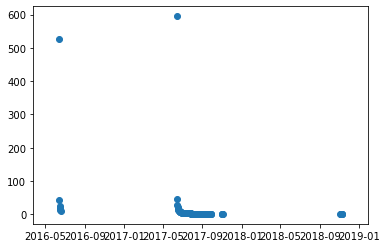

In [107]:
plt.scatter(isolate_mhws['time'], isolate_mhws['performance']/isolate_mhws['performance_clim'])


In [108]:
## Find MHW event with highest performance ratio

In [109]:
isolate_mhws['performance_ratio'] = isolate_mhws.performance / isolate_mhws.performance_clim

In [110]:
isolate_mhws.groupby('mhw').performance_ratio.median().replace(np.inf, np.nan).dropna().sort_values(ascending=False)

mhw
54.0    22.711207
59.0     2.549762
60.0     2.247832
62.0     2.130037
Name: performance_ratio, dtype: float64

Going to pick 59 because 54 seems anaomalous and short

In [167]:
selected_mhw = isolate_mhws[isolate_mhws.mhw == 59]

In [168]:
selected_mhw

,isolate,time,lat,lon,clim_seas,clim_thresh,duration,index_end,index_peak,index_start,...,intensity_var,mhw,performance,performance_clim,rate_decline,rate_onset,tmax,tmin,topt,performance_ratio
29025,79,2017-06-13,22.875,-158.125,24.925281,25.729677,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.129878,0.000218,0.012269,0.025923,31.054467,24.923578,28.758789,594.780489
29026,79,2017-06-14,22.875,-158.125,24.945234,25.742580,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.132378,0.002778,0.012269,0.025923,31.054467,24.923578,28.758789,47.656181
29027,79,2017-06-15,22.875,-158.125,24.964380,25.754645,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.141093,0.005235,0.012269,0.025923,31.054467,24.923578,28.758789,26.953803
29028,79,2017-06-16,22.875,-158.125,24.982917,25.765290,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.163227,0.007614,0.012269,0.025923,31.054467,24.923578,28.758789,21.437008
29029,79,2017-06-17,22.875,-158.125,25.000750,25.775096,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.153443,0.009904,0.012269,0.025923,31.054467,24.923578,28.758789,15.492505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29128,79,2017-09-24,22.875,-158.125,26.290843,27.133903,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.283677,0.173018,0.012269,0.025923,31.054467,24.923578,28.758789,1.639574
29129,79,2017-09-25,22.875,-158.125,26.288368,27.127354,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.288262,0.172720,0.012269,0.025923,31.054467,24.923578,28.758789,1.668951
29130,79,2017-09-26,22.875,-158.125,26.285043,27.120483,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.290964,0.172319,0.012269,0.025923,31.054467,24.923578,28.758789,1.688514
29131,79,2017-09-27,22.875,-158.125,26.281081,27.112870,109.0,13177.0,13100.0,13069.0,...,0.197664,59.0,0.293628,0.171842,0.012269,0.025923,31.054467,24.923578,28.758789,1.708712


In [169]:
selected_mhw.columns

Index(['isolate', 'time', 'lat', 'lon', 'clim_seas', 'clim_thresh', 'duration',
       'index_end', 'index_peak', 'index_start', 'intensity_cumulative',
       'intensity_max', 'intensity_mean', 'intensity_var', 'mhw',
       'performance', 'performance_clim', 'rate_decline', 'rate_onset', 'tmax',
       'tmin', 'topt', 'performance_ratio'],
      dtype='object')

In [170]:
selected_sst = oisst.sel(lat = selected_mhw.lat.iloc[0], lon = selected_mhw.lon.iloc[0], time = slice(selected_mhw.time.min(), selected_mhw.time.max()))

In [210]:
other_year_sst = oisst.sel(
    lat = selected_mhw.lat.iloc[0],
    lon = selected_mhw.lon.iloc[0],
    time = slice(
        selected_mhw.time.min() + np.timedelta64(365, "D"),
        selected_mhw.time.max() + np.timedelta64(365, 'D')
    )
)

In [211]:
selected_sst

<xarray.Dataset>
Dimensions:  (time: 108)
Coordinates:
    lat      float32 22.875
    lon      float32 -158.125
  * time     (time) datetime64[ns] 2017-06-13 2017-06-14 ... 2017-09-28
Data variables:
    sst      (time) float32 dask.array<chunksize=(31,), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    institution:    NOAA/NCDC
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    title:          NOAA High-resolution Blended Analysis: Daily Values using...

(0, 1)

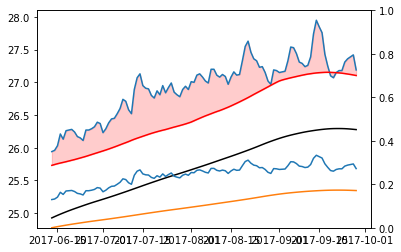

In [173]:
plt.plot(selected_sst.time, selected_sst.sst)
plt.plot(selected_mhw.time, selected_mhw.clim_seas, color='black')
plt.fill_between(selected_mhw.time, selected_mhw.clim_thresh, selected_sst.sst, color='red', alpha=0.2)
plt.plot(selected_mhw.time, selected_mhw.clim_thresh, color='red')

ax2 = plt.twinx()
ax2.plot(selected_mhw.time, selected_mhw.performance)
ax2.plot(selected_mhw.time, selected_mhw.performance_clim)
ax2.set_ylim([0, 1])


## Get Sentinel 3

In [174]:
 from datetime import datetime

In [175]:
s3_api = sentinelsat.SentinelAPI('tonycan', os.environ['ss_pass'], api_url = 'https://codarep.eumetsat.int/')

In [176]:
isolate_mhw_wkt = wkt.dumps(
    geometry.Point([
        selected_mhw.lon.iloc[0],
        selected_mhw.lat.iloc[0]
    ]).buffer(0.01)
)

In [179]:
s3_query = s3_api.query(
    area=isolate_mhw_wkt,
    producttype='OL_2_WFR___',
    date = (selected_mhw.time.min() , selected_mhw.time.max()), 
)

In [181]:
s3_results = s3_api.to_geodataframe(s3_query)

In [194]:
s3_results.columns

Index(['summary', 'ecmwf', 'productlevel', 'platformname',
       'platformidentifier', 'format', 'filename', 'instrumentname',
       'instrumentshortname', 'sensoroperationalmode', 'mode', 'producttype',
       'timeliness', 'size', 'pduduration', 'orbitdirection', 'relorbitdir',
       'relpassnumber', 'relpassdirection', 'passnumber', 'passdirection',
       'processingname', 'processinglevel', 'procfacilityname',
       'procfacilityorg', 'onlinequalitycheck', 'identifier', 'uuid',
       'beginposition', 'endposition', 'creationdate', 'ingestiondate',
       'collection', 'link', 'link_alternative', 'link_icon', 'title',
       'salinewatercoverpercentage', 'coastalcoverpercentage',
       'tidalregioncoverpercentage', 'freshwatercoverpercentage',
       'orbitnumber', 'relativeorbitnumber', 'cyclenumber',
       'cloudcoverpercentage', 'landcoverpercentage', 'geometry'],
      dtype='object')

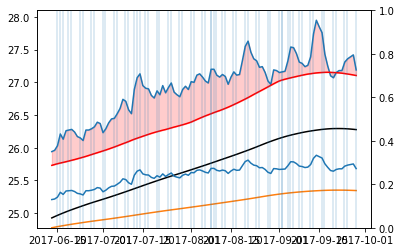

In [199]:
plt.plot(selected_sst.time, selected_sst.sst)
plt.plot(selected_mhw.time, selected_mhw.clim_seas, color='black')
plt.fill_between(selected_mhw.time, selected_mhw.clim_thresh, selected_sst.sst, color='red', alpha=0.2)
plt.plot(selected_mhw.time, selected_mhw.clim_thresh, color='red')

ax2 = plt.twinx()
ax2.plot(selected_mhw.time, selected_mhw.performance)
ax2.plot(selected_mhw.time, selected_mhw.performance_clim)
ax2.set_ylim([0, 1])
[plt.axvline(i,alpha=0.2) for i in s3_results.beginposition];

In [236]:
s3_api_new = sentinelsat.SentinelAPI('tonycan', os.environ['ss_pass'], api_url = 'https://coda.eumetsat.int/')

In [226]:
selected_mhw.time.min() + np.timedelta64(365, 'D')


Timestamp('2018-06-13 00:00:00')

In [241]:
s3_query_future = s3_api_new.query(
    area=isolate_mhw_wkt,
    producttype='OL_2_WFR___',
    date = (
        selected_mhw.time.min() + np.timedelta64(365, 'D') ,
        selected_mhw.time.max() + np.timedelta64(365, 'D')
    )
)

In [242]:
s3_future = s3_api_new.to_geodataframe(s3_query_future)

In [243]:
s3_future

""
